In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

In [2]:
import scipy.stats as spstats
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.scatter as sct

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# Receptive Field settings
traceid='traces001'
response_type='dff'
do_spherical_correction=False
is_neuropil = False

pplot.set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette()

In [4]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# meta['session_int'] = meta['session'].astype(int)

# dsets = meta[(meta.experiment==experiment) & (meta.visual_area==va)
#             & (meta['session_int']>=20190511)].copy()
# dsets

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [5]:
basedir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter')
print(basedir)
if not os.path.exists(basedir):
    os.makedirs(basedir)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter


In [6]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [46]:
# va='V1'
# dk = '20190617_JC097_fov1'

# df_ = sct.load_results(dk, va)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

In [58]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [59]:
missing=[]
d_list=[]
for (va, dk, exp), g in meta.groupby(['visual_area', 'datakey', 'experiment']):
    df_ = sct.load_results(dk, va, exp, verbose=False)
    if df_ is None:
        missing.append((va, dk, exp))
        continue
    df_['visual_area'] = va
    df_['datakey'] = dk
    df_['experiment'] = exp
    d_list.append(df_)

In [60]:
missing

[('V1', '20190615_JC097_fov2', 'rfs10'),
 ('V1', '20191004_JC110_fov2', 'rfs10')]

In [61]:
df = pd.concat(d_list, axis=0)
df.shape

(5260, 7)

In [62]:
%matplotlib inline

In [63]:
bw_colors=dict((v, [0.7]*3) for v in visual_areas)
axis_colors={'az': [0.7]*3,
             'el': [0.5]*3}

In [64]:
df.groupby(['experiment', 'visual_area']).count()

cell  deg_scatter  dist_scatter  axis  datakey
experiment visual_area                                                
rfs        Li            140          140           140   140      140
           Lm            858          858           858   858      858
           V1           1632         1632          1632  1632     1632
rfs10      Li           1448         1448          1448  1448     1448
           Lm            226          226           226   226      226
           V1            956          956           956   956      956

In [65]:
df[df.datakey=='20191111_JC117_fov1']

,cell,deg_scatter,dist_scatter,axis,visual_area,datakey,experiment
0,38,8.313164,3915.552410,az,Lm,20191111_JC117_fov1,rfs10
1,57,6.862749,3232.397797,az,Lm,20191111_JC117_fov1,rfs10
2,58,2.337092,1100.785039,az,Lm,20191111_JC117_fov1,rfs10
3,78,14.294227,6732.670514,az,Lm,20191111_JC117_fov1,rfs10
4,80,8.369437,3942.057070,az,Lm,20191111_JC117_fov1,rfs10
...,...,...,...,...,...,...,...
37,198,2.764886,418.190641,el,V1,20191111_JC117_fov1,rfs10
38,208,1.965224,297.241331,el,V1,20191111_JC117_fov1,rfs10
39,219,2.965105,448.473895,el,V1,20191111_JC117_fov1,rfs10
40,222,0.788802,119.306808,el,V1,20191111_JC117_fov1,rfs10


In [66]:
r_=[]
for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
    regr_ = sct.load_models(dk, va)
    regr_['visual_area'] = va
    regr_['datakey'] = dk
    r_.append(regr_)
REGR = pd.concat(r_, axis=0)


In [108]:
pass_regr = REGR[REGR['R2']>=0.5].copy()
REGR.shape, pass_regr.shape

((108, 9), (71, 9))

In [215]:
round(0.46, 1)

0.5

In [197]:
r2_thr=0.5
pass_regr = pd.concat([r for (va, dk), r in REGR.groupby(['visual_area', 'datakey'])\
                       if (round(r[r.cond=='az']['R2'].values[0], 1)>=r2_thr) 
                       and (round(r[r.cond=='el']['R2'].values[0], 1)>=r2_thr)])

In [198]:
pass_regr[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    15
Lm    10
Li     6
Name: visual_area, dtype: int64

In [216]:
passdf = pd.concat([g for (va, dk), g in df.groupby(['visual_area', 'datakey'])\
           if not pass_regr.query('@va==visual_area and @dk==datakey').empty])

In [292]:
f_=[]
for (va, dk), g in passdf.groupby(['visual_area', 'datakey']):
    if va=='Lm' and dk in['20190430_JC078_fov1', '20190508_JC083_fov1']:
        continue
    if va in ['V1', 'Lm']:
        if 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
        elif 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
    elif va=='Li':
        if 'rfs10' in g['experiment'].values:
            df_ = g[g.experiment=='rfs10'].copy()
        elif 'rfs' in g['experiment'].values:
            df_ = g[g.experiment=='rfs'].copy()
    df_['n_cells'] = len(g['cell'].unique())
    f_.append(df_)
finaldf0 = pd.concat(f_, axis=0)

In [293]:
min_ncells = 10
DF = finaldf0[finaldf0['n_cells']>=min_ncells]

In [294]:
counts = DF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)

In [295]:
finaldf = pd.concat([g for (va, dk), g in DF.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print(finaldf0.shape,DF.shape, finaldf.shape)

(2572, 8) (2546, 8) (2092, 8)


In [296]:
k1 = finaldf['datakey'].unique()
k0 = finaldf0['datakey'].unique()
len(k1)

20

In [297]:
va='Lm'
np.unique([k for k in finaldf0[finaldf0.visual_area==va]['datakey'] \
 if k not in finaldf[finaldf.visual_area==va]['datakey'].values])

array(['20190506_JC080_fov1', '20190517_JC083_fov1'], dtype='<U19')

In [298]:
importlib.reload(pplot)
%matplotlib notebook
import analyze2p.stats as pstats

| visual_area   |   datakey |
|:--------------|----------:|
| Li            |         6 |
| Lm            |         8 |
| V1            |        14 |


<IPython.core.display.Javascript object>


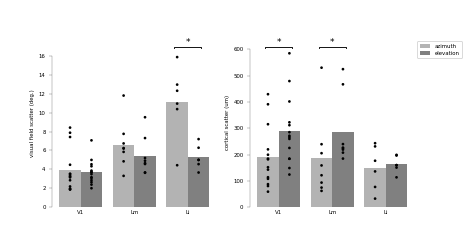

In [299]:
plotd = finaldf0.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
print(plotd[['visual_area', 'datakey']]\
      .drop_duplicates().groupby(['visual_area']).count()['datakey'].to_markdown())
s_=[]
fig, axn = pl.subplots(1,2, figsize=(8, 4))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', palette=axis_colors, ci=None)
    sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
              order=visual_areas, hue='axis', dodge=True,
              jitter=False, size=3,
              palette=dict((k, 'k') for k in ['az', 'el']))
    ylabel = 'cortical scatter (um)' if metric=='dist_scatter' \
                else 'visual field scatter (deg.)'
    ax.set_ylabel(ylabel)
    if metric=='dist_scatter':
        offset=20; h=5;
    else:
        offset=1; h=.1;
    # stats
    statdf = pstats.paired_ttests(plotd, metric=metric, c1='az', c2='el',
                                        compare_var='axis', ttest=False)
    statdf['metric'] = metric
    s_.append(statdf)
    pplot.annotate_sig_on_paired_plot(ax, plotd, statdf, metric, offset=offset, h=h)
    ax.legend_.remove()
# custom legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors['az'], axis_colors['el']],
                                   labels=['azimuth', 'elevation'],
                                   marker=None)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.8, wspace=0.2, bottom=0.2, top=0.85)
sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

figname = 'scatter_perFOV'
pl.savefig(os.path.join(basedir, '%s.svg' % figname))

In [360]:
importlib.reload(pplot)
%matplotlib notebook

<IPython.core.display.Javascript object>


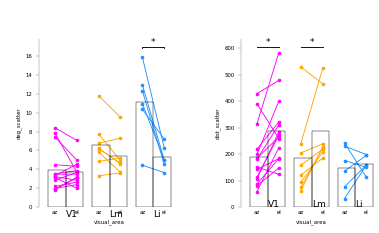

|    |   t_stat |   p_val | visual_area   | metric       |
|---:|---------:|--------:|:--------------|:-------------|
|  0 |       52 |   1     | V1            | deg_scatter  |
|  1 |        6 |   0.109 | Lm            | deg_scatter  |
|  2 |        0 |   0.031 | Li            | deg_scatter  |
|  0 |       10 |   0.005 | V1            | dist_scatter |
|  1 |        3 |   0.039 | Lm            | dist_scatter |
|  2 |        9 |   0.844 | Li            | dist_scatter |


In [301]:
# Paired: spstats.wilcoxon()
offset=2
fig, axn = pl.subplots(1,2, figsize=(6.5, 4))
fig.patch.set_facecolor('w')

s_=[]
for ai, metric in enumerate(['deg_scatter', 'dist_scatter']):
    ax=axn[ai]
    ax, pstats = pplot.pairwise_compare_single_metric(plotd, 
                 curr_metric=metric, ax=ax, size=3,
                 c1='az', c2='el', compare_var='axis', 
                 ttest=False, return_stats=True, bar_ci=None)
    pstats['metric'] = metric
    if metric=='dist_scatter':
        offset=20; h=2;
    else:
        offset=1; h=.1;
    pplot.annotate_sig_on_paired_plot(ax, plotd, pstats, metric, offset=offset, h=h)
    s_.append(pstats)
statsdf = pd.concat(s_)
print(statsdf.to_markdown())

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, bottom=0.2, top=0.85)

figname = 'scatter_perFOV_paired'
pl.savefig(os.path.join(basedir, '%s.svg' % figname))

In [302]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('deg_scatter ~ C(visual_area) + C(axis) + C(visual_area):C(axis)', \
            data=plotd).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(visual_area),169.467274,2.0,17.670999,0.000002
C(axis),41.796780,1.0,8.716619,0.004793
C(visual_area):C(axis),67.501042,2.0,7.038591,0.002026
Residual,239.753391,50.0,NaN,NaN


#### Cortical magnification

In [415]:
import analyze2p.stats as pstats
import statsmodels.api as sm

In [413]:

regr_df = pd.concat([g for (va, dk), g in pass_regr.groupby(['visual_area', 'datakey'])\
                     if not plotd.query('@va==visual_area and @dk==datakey').empty])
print(regr_df[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())
regr_df['cortical_mag'] = np.abs(1./regr_df['coefficient'])

|    |   visual_area |
|:---|--------------:|
| V1 |            14 |
| Lm |             8 |
| Li |             6 |


In [414]:
cmag_df = regr_df[['visual_area','datakey']].drop_duplicates().reset_index(drop=True)
cmag_df['cortical_mag'] = None
cmag_df['cortical_mag_ratio'] = None
for (va, dk), cg in cmag_df.groupby(['visual_area', 'datakey']):
    r_df = regr_df[(regr_df.visual_area==va) & (regr_df.datakey==dk)].copy()
    mean_mag = r_df['coefficient'].abs().mean()
    ratio_mag = float(r_df[r_df.cond=='el']['cortical_mag'])\
                /float(r_df[r_df.cond=='az']['cortical_mag'])
    cmag_df.loc[cg.index, 'cortical_mag'] = mean_mag
    cmag_df.loc[cg.index, 'cortical_mag_ratio'] = ratio_mag
cmag_df['cortical_mag'] = abs(cmag_df['cortical_mag'].astype(float))
cmag_df['cortical_mag_ratio'] = abs(cmag_df['cortical_mag_ratio'].astype(float))


In [416]:
%matplotlib notebook

<IPython.core.display.Javascript object>


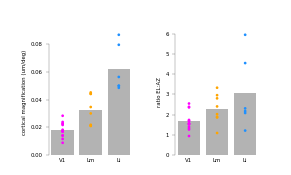

|    | Contrast    | A   | B   | Paired   | Parametric   |   U-val | Tail      |       p-unc |      p-corr | p-adjust   |   hedges | metric             |
|---:|:------------|:----|:----|:---------|:-------------|--------:|:----------|------------:|------------:|:-----------|---------:|:-------------------|
|  0 | visual_area | Li  | Lm  | False    | False        |      48 | one-sided | 0.00120732  | 0.00181099  | fdr_bh     | 1.9906   | cortical_mag       |
|  1 | visual_area | Li  | V1  | False    | False        |      84 | one-sided | 0.000309827 | 0.000929482 | fdr_bh     | 4.20146  | cortical_mag       |
|  2 | visual_area | Lm  | V1  | False    | False        |      98 | one-sided | 0.00230947  | 0.00230947  | fdr_bh     | 1.82997  | cortical_mag       |
|  0 | visual_area | Li  | Lm  | False    | False        |      29 | one-sided | 0.280638    | 0.280638    | fdr_bh     | 0.544505 | cortical_mag_ratio |
|  1 | visual_area | Li  | V1  | False    | False        |      62 | one-sid

In [428]:
s_=[]
fig, axn = pl.subplots(1,2, figsize=(5,3))
fig.patch.set_facecolor('w')
for ai, metric in enumerate(['cortical_mag', 'cortical_mag_ratio']):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=cmag_df, ax=ax,
              order=visual_areas, ci=None, palette=bw_colors)
    sns.stripplot(x='visual_area', y=metric, data=cmag_df, ax=ax,
              order=visual_areas, dodge=True,
              jitter=False, size=3, palette=area_colors)
    stats = pg.pairwise_ttests(dv=metric, between='visual_area', data=cmag_df,
                           subject='datakey', tail='one-sided', # use one-talied bec pos
                           padjust='fdr_bh', parametric=False)
    stats['metric'] = metric
    s_.append(stats)
    ylabel = 'cortical magnification (um/deg)' if ai==0 \
                else 'ratio EL:AZ'
    ax.set_ylabel(ylabel)
statsdf = pd.concat(s_)

sns.despine(bottom=True, trim=True)
for ax in axn:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
pl.subplots_adjust(left=0.15, right=0.8, bottom=0.2, top=0.85, wspace=0.5)
print(statsdf.to_markdown())

pl.savefig(os.path.join(basedir, 'cortical_magnification.svg'))
print(basedir)

In [126]:
import pingouin as pg

<AxesSubplot:xlabel='visual_area', ylabel='deg_scatter'>

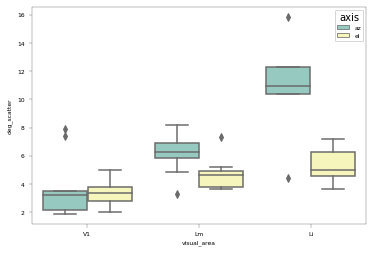

In [127]:
sns.boxplot(x='visual_area', y='deg_scatter', hue='axis', data=plotd, 
            order=visual_areas, palette='Set3')

In [128]:
plotd['subject'] = None
for vi, ((va, dk), g) in enumerate(plotd.groupby(['visual_area','datakey'])):
#     dkeys = list(plotd[plotd.visual_area==va]['datakey'].unique())
#     ix = dkeys.index(dk)
#     print(dk, ix)
    plotd.loc[g.index, 'subject'] = vi

In [129]:
aov_deg = pg.mixed_anova(data=plotd, dv='deg_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_deg

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,visual_area,154.516727,2,23,77.258364,16.516016,0.000036,0.495876,NaN
1,axis,35.673000,1,23,35.673000,16.575988,0.000471,0.185064,1.0
2,Interaction,48.845149,2,23,24.422575,11.348312,0.000373,0.237190,NaN


In [130]:
aov_dist = pg.mixed_anova(data=plotd, dv='dist_scatter', between='visual_area',
                     within='axis', subject='subject', effsize='ng2')
aov_dist

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,visual_area,33036.714330,2,23,16518.357165,1.168520,0.328607,0.071769,NaN
1,axis,109658.546286,1,23,109658.546286,24.689839,0.000050,0.204228,1.0
2,Interaction,7570.814142,2,23,3785.407071,0.852292,0.439469,0.017410,NaN


In [131]:
# Having calculated the ANOVA, we can now run pairwise T-tests. By default, 
# Pingouin will calculate the within between interaction (in this case, year sex).
metric='deg_scatter'
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject')

,Contrast,axis,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,axis,-,az,el,True,True,3.011395,25.000000,two-sided,0.005875,7.409,0.607665
1,visual_area,-,Li,Lm,False,True,2.165603,4.792596,two-sided,0.084968,1.758,1.415811
2,visual_area,-,Li,V1,False,True,3.837025,4.911267,two-sided,0.012581,19.29,2.527366
3,visual_area,-,Lm,V1,False,True,3.894948,18.830658,two-sided,0.000988,30.617,1.598764
4,axis * visual_area,az,Li,Lm,False,True,2.373711,4.578587,two-sided,0.068366,2.224,1.589379
5,axis * visual_area,az,Li,V1,False,True,3.718771,4.804768,two-sided,0.014754,16.052,2.496410
6,axis * visual_area,az,Lm,V1,False,True,3.500807,18.999999,two-sided,0.002391,15.139,1.417999
7,axis * visual_area,el,Li,Lm,False,True,0.826445,6.929512,two-sided,0.436080,0.569,0.461697
8,axis * visual_area,el,Li,V1,False,True,2.919681,5.317704,two-sided,0.030692,4.881,1.806415
9,axis * visual_area,el,Lm,V1,False,True,3.034144,14.571181,two-sided,0.008597,6.842,1.335328


In [132]:
# To get the between * within interaction, one can use the within_first argument:
pg.pairwise_ttests(data=plotd, dv=metric, between='visual_area', 
                   within='axis', subject='subject', within_first=False)


,Contrast,visual_area,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,visual_area,-,Li,Lm,False,True,2.165603,4.792596,two-sided,0.084968,1.758,1.415811
1,visual_area,-,Li,V1,False,True,3.837025,4.911267,two-sided,0.012581,19.29,2.527366
2,visual_area,-,Lm,V1,False,True,3.894948,18.830658,two-sided,0.000988,30.617,1.598764
3,axis,-,az,el,True,True,3.011395,25.000000,two-sided,0.005875,7.409,0.607665
4,visual_area * axis,Li,az,el,True,True,3.452505,4.000000,two-sided,0.025995,3.541,1.589782
5,visual_area * axis,Lm,az,el,True,True,2.887023,8.000000,two-sided,0.020292,3.644,1.082110
6,visual_area * axis,V1,az,el,True,True,0.412744,11.000000,two-sided,0.687725,0.309,0.122450


In [133]:
# shapiro-test (should b p>0.05 if noramally distributed)
pg.

#  homogeneity of variance assumption of the between-subject factor (group) 
# can be checked using the Levene’s test
pg. # (homogeneuity of variances if p>0.05)


SyntaxError: invalid syntax (<ipython-input-133-dfeb65c92e4c>, line 2)

In [134]:
k = plotd['visual_area'].nunique()  # Number of groups
n = plotd.shape[0] / k  # Number of observations per group
print(k, n)
achieved_power = pg.power_anova(eta=aov.loc[0, 'ng2'], k=k, n=n, alpha=0.05)
print('Achieved power: %.4f' % achieved_power)

3 17.333333333333332


NameError: name 'aov' is not defined

In [135]:
pg.pairwise_tukey(data=plotd, dv='deg_scatter', between='axis', within='visual_area')


TypeError: pairwise_tukey() got an unexpected keyword argument 'within'

In [136]:
plotd

,visual_area,datakey,axis,cell,deg_scatter,dist_scatter,subject
0,Li,20190527_JC092_fov3,az,79.693878,4.436419,32.481144,0
1,Li,20190527_JC092_fov3,el,79.693878,3.665362,159.458303,0
2,Li,20190617_JC099_fov1,az,40.550000,10.956967,76.810475,1
3,Li,20190617_JC099_fov1,el,40.550000,5.012103,159.682500,1
4,Li,20191017_JC113_fov1,az,164.903846,15.875299,230.820891,2
5,Li,20191017_JC113_fov1,el,164.903846,6.286676,198.714451,2
6,Li,20191106_JC120_fov1,az,102.785714,12.314810,176.319935,3
7,Li,20191106_JC120_fov1,el,102.785714,4.552553,150.431881,3
8,Li,20191111_JC120_fov1,az,102.000000,10.372008,135.870612,4
9,Li,20191111_JC120_fov1,el,102.000000,7.199394,196.197021,4


In [317]:
posthocs = pg.pairwise_ttests(dv='deg_scatter', within=['visual_area', 'axis'],
                             subject='datakey', data=plotd)
posthocs

ValueError: Repeated measures dataframe is not balanced. `Subjects` must have the same number of elements in all conditions, even when missing values are present.

In [324]:
pg.sphericity(data=plotd, dv='deg_scatter', subject='datakey', 
              within=['visual_area', 'axis'])[-1]

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/frame.py:8525: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


LinAlgError: Eigenvalues did not converge